In [12]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Reshape, UpSampling2D, BatchNormalization, Dropout, Flatten, Activation

from keras.datasets import mnist, cifar10

import matplotlib.pyplot as plt
%matplotlib inline

# Load & prep data

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [4]:
corruption_level = 0.1
# add random noise
x_train_noisy = X_train + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_test_noisy = X_test + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


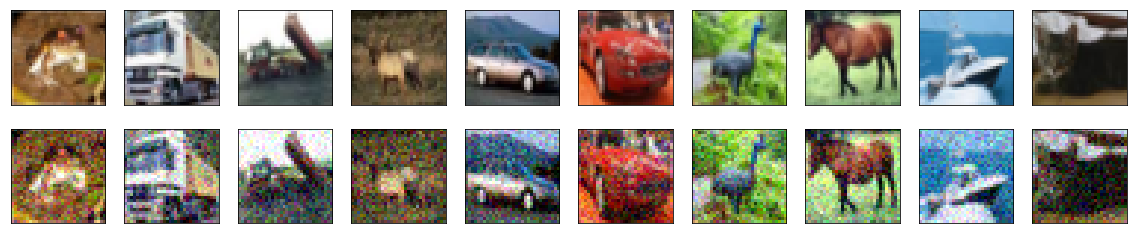

In [4]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(x_train_noisy[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
# convenience testing func
def test_autoencoder(autoencoder, X_test, X_test_noisy):
    decoded_imgs = autoencoder.predict(X_test_noisy)
    
    plt.figure(figsize=(12, 4))
    for i in range(10):
        # display original
        ax = plt.subplot(3, 10, i + 1)
        plt.imshow(X_test[i].reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noise
        ax = plt.subplot(3, 10, i + 11)
        plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, 10, i + 21)
        plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Build model

In [16]:
# encoding
inputs = Input(shape=(32, 32, 3))
x = Conv2D(filters=128, kernel_size=5, activation='elu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Dense(512)(x)
x = MaxPooling2D(padding='same')(x)
x = Conv2D(filters=64, kernel_size=4, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dense(1024)(x)
x = MaxPooling2D(padding='same')(x)
x = Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dense(2048)(x)
x = Dropout(0.3)(x)
encoder = MaxPooling2D(padding='same')(x)

# decoding
x = Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dense(2048)(x)
x = UpSampling2D()(x)
x = Conv2D(filters=64, kernel_size=4, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dense(1024)(x)
x = UpSampling2D()(x)
x = Conv2D(filters=128, kernel_size=5, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dense(512)(x)
x = Dropout(0.3)(x)
decoder = Conv2D(filters=3, kernel_size=3, activation='sigmoid', padding='same')(x)

# autoencoder
autoencoder = Model(inputs, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
dense_19 (Dense)             (None, 32, 32, 512)       66048     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        524352    
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 16, 64)        256       
__________

# Train model

In [18]:
autoencoder.fit(x_train_noisy, X_train, epochs=1, batch_size=64, validation_data=(x_test_noisy, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 453s 9ms/step - loss: 0.5743 - val_loss: 0.5612


In [ ]:
# 0.645
# 0.6059 adding dense(256) after batch norms
# 0.5866 dropped CNN stacks to 2x and increased dense(256) to 2x
# 0.5665 reducing CNN stacks to 1x, increased dense layers to 256/512/1024
# 0.5616 increased dense layers to 512/1024/2048
# 0.5612 changing activations from relu to elu

In [19]:
autoencoder.optimizer.lr = 0.1

In [20]:
autoencoder.fit(x_train_noisy, X_train, epochs=5, batch_size=64, validation_data=(x_test_noisy, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 452s 9ms/step - loss: 0.5594 - val_loss: 0.5588
Epoch 2/5
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5571 - val_loss: 0.5579
Epoch 3/5
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5564 - val_loss: 0.5595
Epoch 4/5
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5557 - val_loss: 0.5602
Epoch 5/5
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5555 - val_loss: 0.5559


In [21]:
autoencoder.optimizer.lr = 0.01

In [ ]:
autoencoder.fit(x_train_noisy, X_train, epochs=50, batch_size=64, validation_data=(x_test_noisy, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5626 - val_loss: 0.6725
Epoch 2/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5714 - val_loss: 0.5658
Epoch 3/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5618 - val_loss: 0.5618
Epoch 4/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5596 - val_loss: 0.5595
Epoch 5/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5582 - val_loss: 0.5580
Epoch 6/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5618 - val_loss: 0.5597
Epoch 7/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5594 - val_loss: 0.5581
Epoch 8/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5576 - val_loss: 0.5787
Epoch 9/50
50000/50000 [==============================] - 451s 9ms/step - loss: 0.5571 - val_loss: 0.5

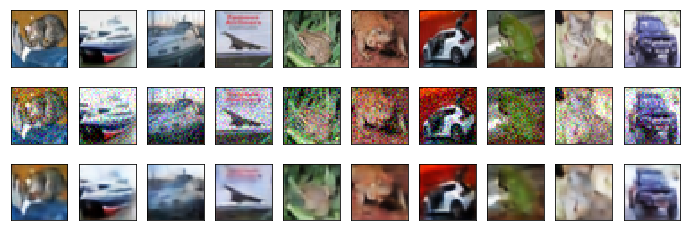

In [25]:
test_autoencoder(autoencoder, X_test, x_test_noisy)

# Trying another architecture

In [19]:
# encoding
inputs = Input(shape=(32, 32, 3))
x = Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(padding='same')(x)
x = Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(padding='same')(x)
x = Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(3072)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
encoder = Activation('sigmoid')(x)

# decoding
x = Dense(3072)(x)
x = BatchNormalization()(x)
x = Reshape((32, 32, 3))(x)
x = Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=3, kernel_size=3, activation='elu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
decoder = Activation('sigmoid')(x)

# autoencoder
autoencoder = Model(inputs, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 32)          0         
__________

In [21]:
# train
autoencoder.fit(x_train_noisy, X_train, epochs=1, batch_size=64, validation_data=(x_test_noisy, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 47s 939us/step - loss: 0.6137 - val_loss: 0.5751


In [22]:
autoencoder.optimizer.lr = 0.1

In [23]:
autoencoder.fit(x_train_noisy, X_train, epochs=5, batch_size=64, validation_data=(x_test_noisy, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 42s 848us/step - loss: 0.6039 - val_loss: 0.5722
Epoch 2/5
50000/50000 [==============================] - 42s 847us/step - loss: 0.6028 - val_loss: 0.5702
Epoch 3/5
50000/50000 [==============================] - 42s 849us/step - loss: 0.6022 - val_loss: 0.5696
Epoch 4/5
50000/50000 [==============================] - 42s 847us/step - loss: 0.6017 - val_loss: 0.5702
Epoch 5/5
50000/50000 [==============================] - 42s 848us/step - loss: 0.6013 - val_loss: 0.5709


In [24]:
autoencoder.optimizer.lr = 0.01

In [25]:
autoencoder.fit(x_train_noisy, X_train, epochs=15, batch_size=64, validation_data=(x_test_noisy, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 42s 847us/step - loss: 0.6011 - val_loss: 0.5681
Epoch 2/15
50000/50000 [==============================] - 42s 844us/step - loss: 0.6009 - val_loss: 0.5680
Epoch 3/15
50000/50000 [==============================] - 42s 845us/step - loss: 0.6008 - val_loss: 0.5650
Epoch 4/15
50000/50000 [==============================] - 42s 846us/step - loss: 0.6006 - val_loss: 0.5684
Epoch 5/15
50000/50000 [==============================] - 42s 846us/step - loss: 0.6005 - val_loss: 0.5685
Epoch 6/15
50000/50000 [==============================] - 42s 848us/step - loss: 0.6004 - val_loss: 0.5680
Epoch 7/15
50000/50000 [==============================] - 42s 846us/step - loss: 0.6003 - val_loss: 0.5667
Epoch 8/15
50000/50000 [==============================] - 42s 846us/step - loss: 0.6001 - val_loss: 0.5640
Epoch 9/15
50000/50000 [==============================] - 42s 846us/step - loss: 0.6000 - val_

This model isn't performing any better than the previous model, but it is training _significantly_ faster. Given accuracy appears to be only slightly worse than the other model, I'd consider this an improvement.

In [26]:
autoencoder.fit(x_train_noisy, X_train, epochs=15, batch_size=64, validation_data=(x_test_noisy, X_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 42s 849us/step - loss: 0.5996 - val_loss: 0.5663
Epoch 2/15
50000/50000 [==============================] - 42s 847us/step - loss: 0.5996 - val_loss: 0.5708
Epoch 3/15
50000/50000 [==============================] - 42s 847us/step - loss: 0.5995 - val_loss: 0.5648
Epoch 4/15
50000/50000 [==============================] - 42s 847us/step - loss: 0.5994 - val_loss: 0.5663
Epoch 5/15
50000/50000 [==============================] - 42s 847us/step - loss: 0.5994 - val_loss: 0.5682
Epoch 6/15
50000/50000 [==============================] - 42s 848us/step - loss: 0.5994 - val_loss: 0.5676
Epoch 7/15
50000/50000 [==============================] - 42s 847us/step - loss: 0.5993 - val_loss: 0.5677
Epoch 8/15
50000/50000 [==============================] - 42s 847us/step - loss: 0.5993 - val_loss: 0.5658
Epoch 9/15
50000/50000 [==============================] - 42s 847us/step - loss: 0.5992 - val_

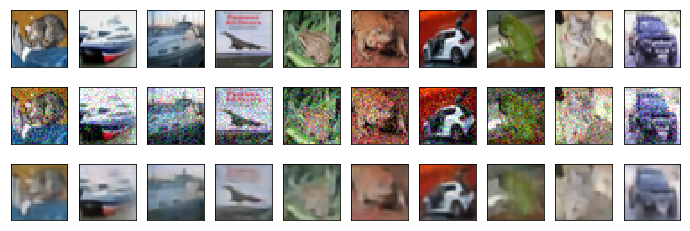

In [27]:
test_autoencoder(autoencoder, X_test, x_test_noisy)